# Transformer Classifier Training on NSL-KDD

This notebook trains a Transformer-based Neural Network for Network Intrusion Detection.

**Model:** TransformerClassifier (PyTorch)  
**Dataset:** NSL-KDD  
**Task:** Binary Classification (Normal vs Attack)

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../..')

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Memory: 6.4 GB


## 2. Load and Preprocess Data

In [2]:
# Column names for NSL-KDD
COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load data
DATA_PATH = '../../data/raw/nsl-kdd/'
train_df = pd.read_csv(DATA_PATH + 'train.txt', header=None, names=COLUMNS)
test_df = pd.read_csv(DATA_PATH + 'test.txt', header=None, names=COLUMNS)

print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")

Training samples: 125,973
Test samples: 22,544


In [3]:
# Binary labeling: Normal (0) vs Attack (1)
train_df['binary_label'] = train_df['label'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['binary_label'] = test_df['label'].apply(lambda x: 0 if x == 'normal' else 1)

print("Training distribution:")
print(train_df['binary_label'].value_counts())
print("\nTest distribution:")
print(test_df['binary_label'].value_counts())

Training distribution:
binary_label
0    67343
1    58630
Name: count, dtype: int64

Test distribution:
binary_label
1    12833
0     9711
Name: count, dtype: int64


In [4]:
# Feature engineering
def preprocess_data(train_df, test_df):
    """
    Preprocess NSL-KDD data for Transformer training.
    """
    # Identify categorical columns
    categorical_cols = ['protocol_type', 'service', 'flag']
    
    # One-hot encode categorical features
    train_encoded = pd.get_dummies(train_df, columns=categorical_cols)
    test_encoded = pd.get_dummies(test_df, columns=categorical_cols)
    
    # Align columns (test may have different categories)
    train_cols = set(train_encoded.columns)
    test_cols = set(test_encoded.columns)
    
    # Add missing columns
    for col in train_cols - test_cols:
        if col not in ['label', 'difficulty_level', 'binary_label']:
            test_encoded[col] = 0
    for col in test_cols - train_cols:
        if col not in ['label', 'difficulty_level', 'binary_label']:
            train_encoded[col] = 0
    
    # Drop non-feature columns
    drop_cols = ['label', 'difficulty_level', 'binary_label']
    feature_cols = [c for c in train_encoded.columns if c not in drop_cols]
    feature_cols = sorted(feature_cols)  # Consistent ordering
    
    X_train = train_encoded[feature_cols].values
    X_test = test_encoded[feature_cols].values
    y_train = train_df['binary_label'].values
    y_test = test_df['binary_label'].values
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, scaler, feature_cols

X_train, X_test, y_train, y_test, scaler, feature_cols = preprocess_data(train_df, test_df)

print(f"Features: {len(feature_cols)}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Features: 122
X_train shape: (125973, 122)
X_test shape: (22544, 122)


In [5]:
# Create validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train: {X_train.shape[0]:,}")
print(f"Val: {X_val.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")

Train: 100,778
Val: 25,195
Test: 22,544


In [6]:
# Create PyTorch DataLoaders
def create_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=256):
    """
    Create PyTorch DataLoaders for training, validation, and testing.
    For Transformer: (batch, seq_len, features) - treat each feature as a token
    """
    # Reshape for Transformer: (batch, seq_len=num_features, feature_dim=1)
    X_train_t = torch.FloatTensor(X_train).unsqueeze(-1)  # (N, 122, 1)
    X_val_t = torch.FloatTensor(X_val).unsqueeze(-1)
    X_test_t = torch.FloatTensor(X_test).unsqueeze(-1)
    
    y_train_t = torch.LongTensor(y_train)
    y_val_t = torch.LongTensor(y_val)
    y_test_t = torch.LongTensor(y_test)
    
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

BATCH_SIZE = 256
train_loader, val_loader, test_loader = create_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test, BATCH_SIZE
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 394
Val batches: 99
Test batches: 89


## 3. Define Transformer Model

In [7]:
class PositionalEncoding(nn.Module):
    """
    Positional encoding for Transformer.
    Adds position information to the input embeddings.
    """
    def __init__(self, d_model, max_len=200, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    """
    Transformer-based classifier for NIDS.
    Treats each feature as a token in a sequence.
    """
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=4, 
                 dim_feedforward=256, num_classes=2, dropout=0.3):
        super(TransformerClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Project input features to d_model dimensions
        self.input_projection = nn.Linear(1, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=input_dim, dropout=dropout)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # x: (batch, seq_len=122, 1)
        
        # Project to d_model dimensions
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoder
        x = self.transformer_encoder(x)  # (batch, seq_len, d_model)
        
        # Global average pooling over sequence
        x = x.mean(dim=1)  # (batch, d_model)
        
        # Classification
        x = self.classifier(x)  # (batch, num_classes)
        
        return x


# Create model
input_dim = X_train.shape[1]  # 122 features
print(f'Input dimension: {input_dim}')

model = TransformerClassifier(
    input_dim=input_dim,
    d_model=128,
    nhead=4,
    num_layers=4,
    dim_feedforward=256,
    num_classes=2,
    dropout=0.3
)
model = model.to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Input dimension: 122
TransformerClassifier(
  (input_projection): Linear(in_features=1, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bi

## 4. Training Configuration

In [8]:
# Hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.0001
EARLY_STOPPING_PATIENCE = 10

# Class weights to handle imbalance (higher weight for Attack class)
class_weights = torch.tensor([1.0, 2.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"Class Weights: {class_weights}")

Epochs: 50
Learning Rate: 0.0001
Batch Size: 256
Early Stopping Patience: 10
Class Weights: tensor([1.0000, 2.5000], device='cuda:0')


## 5. Training Loop

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    return total_loss / total, correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    return total_loss / total, correct / total

In [10]:
# Training
print("Starting Training...")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
best_model_state = None
patience_counter = 0
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        save_marker = "*"
    else:
        patience_counter += 1
        save_marker = ""
    
    # Print progress
    print(f"Epoch {epoch:3d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} {save_marker}")
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping at epoch {epoch}")
        break

# Restore best model
model.load_state_dict(best_model_state)

training_time = time.time() - start_time
print(f"\nTraining complete! Time: {training_time/60:.1f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Starting Training...
Epoch   1/50 | Train Loss: 0.3269 | Train Acc: 0.8276 | Val Loss: 0.4135 | Val Acc: 0.7815 *
Epoch   2/50 | Train Loss: 0.2045 | Train Acc: 0.9094 | Val Loss: 0.2101 | Val Acc: 0.9036 *
Epoch   3/50 | Train Loss: 0.1456 | Train Acc: 0.9440 | Val Loss: 0.1986 | Val Acc: 0.9370 *
Epoch   4/50 | Train Loss: 0.1243 | Train Acc: 0.9566 | Val Loss: 0.1954 | Val Acc: 0.9351 
Epoch   5/50 | Train Loss: 0.1109 | Train Acc: 0.9601 | Val Loss: 0.1610 | Val Acc: 0.9403 *
Epoch   6/50 | Train Loss: 0.0977 | Train Acc: 0.9631 | Val Loss: 0.1695 | Val Acc: 0.9326 
Epoch   7/50 | Train Loss: 0.0904 | Train Acc: 0.9646 | Val Loss: 0.1912 | Val Acc: 0.9273 
Epoch   8/50 | Train Loss: 0.0835 | Train Acc: 0.9660 | Val Loss: 0.1574 | Val Acc: 0.9346 
Epoch   9/50 | Train Loss: 0.0783 | Train Acc: 0.9669 | Val Loss: 0.1389 | Val Acc: 0.9358 
Epoch  10/50 | Train Loss: 0.0758 | Train Acc: 0.9687 | Val Loss: 0.1317 | Val Acc: 0.9313 
Epoch  11/50 | Train Loss: 0.0697 | Train Acc: 0.9703 |

## 6. Training Visualization

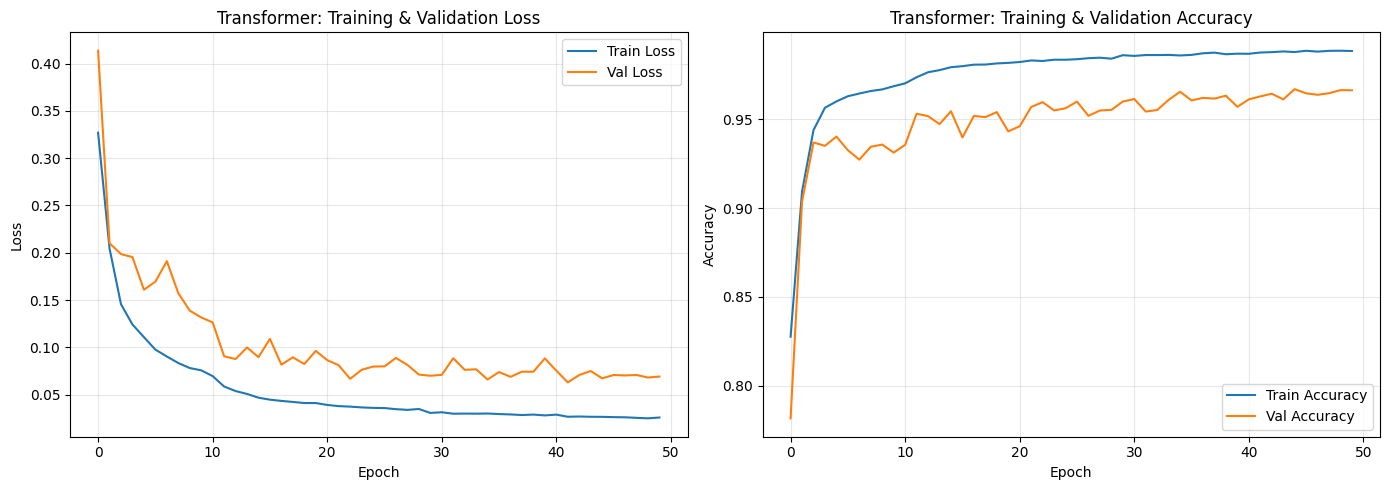

Training plot saved!


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Transformer: Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy')
axes[1].plot(history['val_acc'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Transformer: Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/figures/transformer_training_history.png', dpi=150)
plt.show()

print("Training plot saved!")

## 7. Model Evaluation

In [12]:
def evaluate_model(model, test_loader, device):
    """
    Full evaluation on test set.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

y_pred, y_true, y_probs = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

TEST SET RESULTS
Accuracy:  0.8753
Precision: 0.9281
Recall:    0.8464
F1-Score:  0.8854


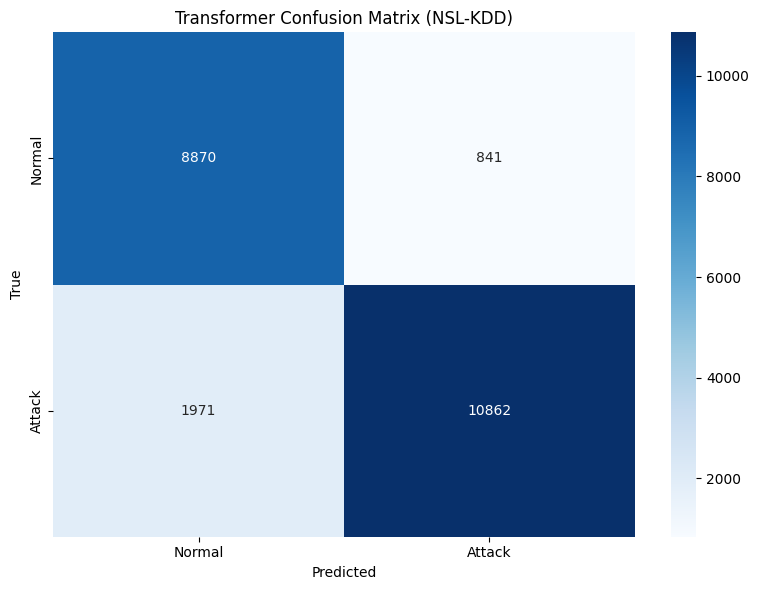


Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      0.91      0.86      9711
      Attack       0.93      0.85      0.89     12833

    accuracy                           0.88     22544
   macro avg       0.87      0.88      0.87     22544
weighted avg       0.88      0.88      0.88     22544



In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Transformer Confusion Matrix (NSL-KDD)')
plt.tight_layout()
plt.savefig('../../results/figures/transformer_confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Attack']))

## 8. Save Model

In [ ]:
import os

# Create directory if it doesn't exist
os.makedirs('../../results/models', exist_ok=True)

# Save model
model_path = '../../results/models/transformer_nsl_kdd.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'd_model': 128,
        'nhead': 4,
        'num_layers': 4,
        'dim_feedforward': 256,
        'num_classes': 2,
        'dropout': 0.3
    },
    'feature_cols': feature_cols,
    'scaler': scaler,
    'history': history,
    'metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
}, model_path)

print(f"Model saved to: {model_path}")

#Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()

Model saved to: ../../results/models/transformer_nsl_kdd.pth


4310

## 7. Comparison with CNN

| Metric | CNN | Transformer |
|--------|-----|-------------|
| Accuracy | 79.96% | 87.53% |
| Attack Recall | 67% | 85% |
| Normal Recall | 97% | 91% |
| Attack Precision | 97% | 93% |
| Normal Precision | 69% | 82% |